# Spectral extraction tests (JDAT-1855)

Notebook contains the following sections:

- Use specreduce's BoxcarExtract. Originally, doesn't work due to the absence of a Trace object and bugs in the code. Fixing bugs and using the trace function from kosmos (slightly modified), we can produce a 1d extraction from s2d data set at https://stsci.app.box.com/s/ywnauuvan1job9jcsqnzjihv6hm1uono (files also live in /eng/ssb/). Resulting spectrum looks correct, but background-subtracted spectrum has wrong flux scaling. Seems over-subtracted.

- Adapt boxcar extraction code from  https://github.com/spacetelescope/jdat_notebooks/tree/main/notebooks/MIRI_LRS_spectral_extraction

- Use the adapted code to extract from same s2d data set as above. 

- Use the adapted code to extract from s3d data set at https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_optimal_extraction/

In [1]:
import os

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
%matplotlib inline

from astropy.io import fits
from astropy.table import Table
from astropy.visualization import simple_norm
from astropy.utils.data import download_file

from jwst import datamodels

from specreduce.extract import BoxcarExtract

import sys
sys.path.insert(0, "/Users/busko/Projects/kosmos/")

import ccdproc
import kosmos

## Ingest s2d data

In [2]:
# data is taken from s2d file. x1d is used for comparison with pipeline extraction.
s2dfilename = "nirspec_fssim_d1_s2d.fits"
x1dfilename = "nirspec_fssim_d1_x1d.fits"
mainurl = "file:/eng/ssb/busko/NIRSpec_s2d/"

s2dfile_dld = download_file(mainurl + s2dfilename)
x1dfile_dld = download_file(mainurl + x1dfilename)

In [3]:
# rename files so that they have the right extensions required for the jwst datamodels to work
s2dfile = s2dfile_dld + '_s2d.fits'
os.rename(s2dfile_dld, s2dfile)
x1dfile = x1dfile_dld + '_x1d.fits'
os.rename(x1dfile_dld, x1dfile)

In [4]:
# use a jwst datamodel to provide a good interface to the data and wcs info
s2d = datamodels.open(s2dfile)
image = s2d.slits[0].data

DEBUG:jwst.datamodels.util:Opening /var/folders/f2/dsq1cxxd78n9vltk6_6kwxtr0000zf/T/astropy-download-14721-zyq73w6l_s2d.fits as <class 'jwst.datamodels.multislit.MultiSlitModel'>


Text(0.5, 1.0, 'slit[0]')

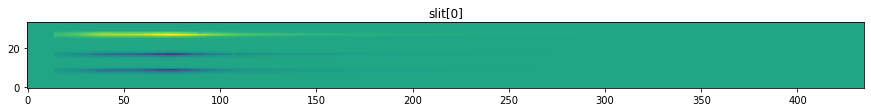

In [5]:
# display s2d image
norm_data = simple_norm(image, "sqrt")
plt.figure(figsize=(15, 15))
plt.imshow(image, norm=norm_data, origin="lower")
plt.title("slit[0]")

<TableColumns names=('WAVELENGTH','FLUX','ERROR','SURF_BRIGHT','SB_ERROR','DQ','BACKGROUND','BERROR','NPIXELS')>


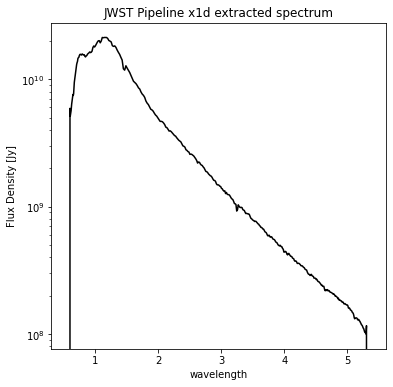

In [6]:
# pipeline 1d extraction (for comparison)
jpipe_x1d = Table.read(x1dfile, hdu=1)
print(jpipe_x1d.columns)
# plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(jpipe_x1d['WAVELENGTH'], jpipe_x1d['FLUX'], 'k-', label="jpipe_x1d")
ax.set_title("JWST Pipeline x1d extracted spectrum")
ax.set_xlabel("wavelength")
ax.set_ylabel("Flux Density [Jy]")
ax.set_yscale("log")

Text(0.5, 1.0, 'slit[0] slice')

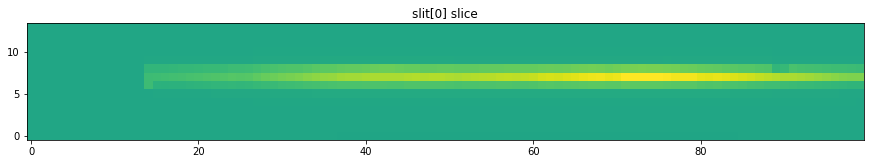

In [7]:
# blow up of the region to be extracted
plt.figure(figsize=(15, 15))
plt.imshow(image[20:35,0:100], norm=norm_data, origin="lower")
plt.title("slit[0] slice")

In [8]:
# extraction parameters based on image above
ext_center = 27
ext_width = 5
bkg_offset = 6
bkg_width = 2

Text(0.5, 1.0, 'Cross-dispersion Cut at Pixel=70')

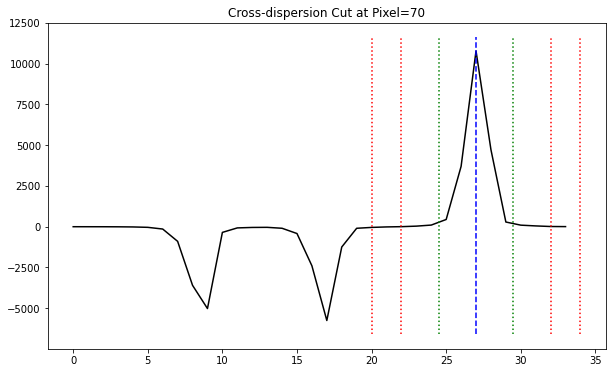

In [9]:
# Plot along cross-disperion cut showing the extraction parameters
fig, ax = plt.subplots(figsize=(10, 6))
y = np.arange(image.shape[0])
ax.plot(y, image[:,70], 'k-')
mm = np.array([ext_center, ext_center])
mm_y = ax.get_ylim()

ax.plot(mm, mm_y, 'b--')
ax.plot(mm - ext_width/2., mm_y, 'g:')
ax.plot(mm + ext_width/2., mm_y, 'g:')

ax.plot(mm - bkg_offset - bkg_width/2., mm_y, 'r:')
ax.plot(mm - bkg_offset + bkg_width/2., mm_y, 'r:')
ax.plot(mm + bkg_offset - bkg_width/2., mm_y, 'r:')
ax.plot(mm + bkg_offset + bkg_width/2., mm_y, 'r:')

ax.set_title("Cross-dispersion Cut at Pixel=70")

## specreduce's BoxcarExtract test with s2d data

In [10]:
# build a trace object
class Trace:
    def __init__(self, image):
        self.line = kosmos.trace(image, Saxis=0)

trace = Trace(image)
# print(trace.line)

In [11]:
# extract (need to fix BoxcarExtract before this can run)
boxcar = BoxcarExtract()
boxcar.apwidth = ext_width
boxcar.skysep = int(bkg_offset - bkg_width/2 - ext_width/2)
boxcar.skywidth = bkg_width

spectrum, bkg_spectrum = boxcar(image, trace)

In [12]:
# print(spectrum.wavelength)

# this one crashes with "UnitConversionError: 'pix' and 'Angstrom' (length) are not convertible"

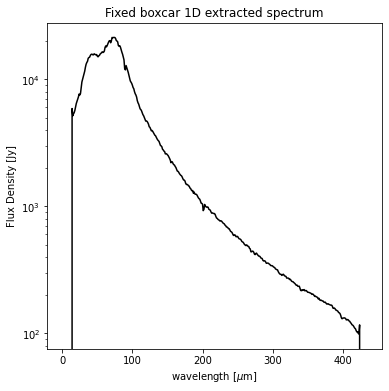

In [13]:
# plot 

fig, ax = plt.subplots(figsize=(6, 6))
# ax.plot(spectrum.wavelength.values, spectrum.flux.values, 'k-', label="boxcar")
ax.plot(spectrum.flux.value, 'k-', label="boxcar")
ax.plot(bkg_spectrum.flux.value, 'k:', label="boxcar (bkgsub)")
# ax.plot(waves_boxcar_bkgsub[gpts], ext1d_boxcar_bkgsub[gpts], 'k:', label="boxcar (bkgsub)")
# ax.plot(jpipe_x1d['FLUX'], 'k-', label="jpipe_x1d")
ax.set_title("Fixed boxcar 1D extracted spectrum")
ax.set_xlabel(r"wavelength [$\mu$m]")
ax.set_ylabel("Flux Density [Jy]")
ax.set_yscale("log")
# ax.legend()

# Extraction code

Functions below are adapted from https://github.com/spacetelescope/jdat_notebooks/tree/main/notebooks/MIRI_LRS_spectral_extraction 

They were rid of the extra code necessary to support wavelength-dependent extraction, and PSF-weighted extraction. These require that a gWCS be present in the input data, which doesn't seem to be the case with s2d files.

These functions were modified to support both 2d and 3d extractions. Serious refactoring is still required to make this into production-level code.

In [14]:
def get_boxcar_weights(center, hwidth, npix):
    """
    Compute the weights given an aperture center, half widths, and number of pixels
    """
    
    # TODO: this code may fail when regions fall partially or entirelly outside the image.
    
    weights = np.zeros((npix))

    # 2d
    if type(npix) is not tuple:
        # pixels with full weight
        fullpixels = [max(0, int(center - hwidth + 1)), min(int(center + hwidth), npix)]
        weights[fullpixels[0] : fullpixels[1]] = 1.0

        # pixels at the edges of the boxcar with partial weight
        if fullpixels[0] > 0:
            weights[fullpixels[0] - 1] = hwidth - (center - fullpixels[0])
        if fullpixels[1] < npix:
            weights[fullpixels[1]] = hwidth - (fullpixels[1] - center)
    # 3d
    else:
        # pixels with full weight
        fullpixels_x = [max(0, int(center[1] - hwidth + 1)), min(int(center[1] + hwidth), npix[1])]
        fullpixels_y = [max(0, int(center[0] - hwidth + 1)), min(int(center[0] + hwidth), npix[0])]
        weights[fullpixels_x[0]:fullpixels_x[1], fullpixels_y[0]:fullpixels_y[1]] = 1.0

        # not yet handling pixels at the edges of the boxcar

    return weights


# def ap_weight_images(center, width, bkg_offset, bkg_width, image_shape, waves, wavescale=None):
def ap_weight_images(center, width, disp_axis, crossdisp_axis, bkg_offset, bkg_width, image_shape):

    """
    Create a weight image that defines the desired extraction aperture
    and the weight image for the requested background regions

    Parameters
    ----------
    center : float
        center of aperture in pixels
    width : float
        width of apeture in pixels
    disp_axis : int
        dispersion axis
    crossdisp_axis : int or tuple
        cross-dispersion axis
    bkg_offset : float
        offset from the extaction edge for the background
        never scaled for wavelength
    bkg_width : float
        width of background region
        never scaled with wavelength
    image_shape : tuple with 2 or 3 elements
        size (shape) of image
    waves : array
        wavelegth values   NOT USED
    wavescale : float
        scale the width with wavelength (default=None)
        wavescale gives the reference wavelenth for the width value  NOT USED

    Returns
    -------
    wimage, bkg_wimage : (2D image, 2D image)
        wimage is the weight image defining the aperature
        bkg_image is the weight image defining the background regions
    """
    wimage = np.zeros(image_shape)
    bkg_wimage = np.zeros(image_shape)
    hwidth = 0.5 * width
    
    if len(crossdisp_axis) == 1:
        # 2d
        image_sizes = image_shape[crossdisp_axis[0]]
    else:
        # 3d
        image_shape_array = np.array(image_shape)
        crossdisp_axis_array = np.array(crossdisp_axis)
        image_sizes = image_shape_array[crossdisp_axis_array]
        image_sizes = tuple(image_sizes.tolist())
        
    # loop in dispersion direction and compute weights
    # 
    # This loop may be removed or highly cleaned up, replaced by 
    # vectorized operations, when the extraction parameters are the 
    # same in every image column. We leave it in place for now, so 
    # the code may be upgraded later to support height-variable and 
    # PSF-weighted extraction modes.

    for i in range(image_shape[disp_axis]):
#         if wavescale is not None:
#             hwidth = 0.5 * width * (waves[i] / wavescale)

        if len(crossdisp_axis) == 1:
            wimage[:, i] = get_boxcar_weights(center, hwidth, image_sizes)
        else:
            wimage[i, ::] = get_boxcar_weights(center, hwidth, image_sizes)
            
        # bkg regions (only for s2d for now)
        if (len(crossdisp_axis) == 1) & (bkg_width is not None) & (bkg_offset is not None):
            bkg_wimage[:, i] = get_boxcar_weights(
                center - hwidth - bkg_offset, bkg_width, image_shape[0]
            )
            bkg_wimage[:, i] += get_boxcar_weights(
                center + hwidth + bkg_offset, bkg_width, image_shape[0]
            )
        else:
            bkg_wimage = None

    return (wimage, bkg_wimage)


# def extract_1dspec(jdatamodel, center, width, bkg_offset, bkg_width, wavescale=None):
def extract_1dspec(image, jdatamodel, center, width, disp_axis, crossdisp_axis, bkg_offset, bkg_width):

    """
    Extract the 1D spectrum using the boxcar method.
    Does a background subtraction as part of the extraction.
    
    We need to pass both the data model and the image array separately because
    different types of data format hold the image in different attributes. This
    api should evolve as we deal with other types of data model.


    Parameters
    ----------
    image : ndarray
        array with 2-D spectral image data
    jdatamodel : jwst.DataModel
        jwst datamodel with the 2d spectral image
    center : float
        center of aperture in pixels
    width : float
        width of apeture in pixels
    disp_axis : int
        dispersion axis
    crossdisp_axis : int or tuple
        cross-dispersion axis
    bkg_offset : float
        offset from the extaction edge for the background
        never scaled for wavelength
    bkg_width : float
        width of background region
        never scaled with wavelength
    wavescale : float
        scale the width with wavelength (default=None)
        wavescale gives the reference wavelenth for the width value NOT USED

    Returns
    -------
    waves, ext1d : (ndarray, ndarray)
        2D `float` array with wavelengths
        1D `float` array with extracted 1d spectrum in Jy
    """
#     # should be determined from the gWCS in cal.fits
#     image = np.transpose(jdatamodel.data)
#     grid = grid_from_bounding_box(jdatamodel.meta.wcs.bounding_box)
#     ra, dec, lam = jdatamodel.meta.wcs(*grid)
#     lam_image = np.transpose(lam)

#     # compute a "rough" wavelength scale to allow for aperture to scale with wavelength
#     rough_waves = np.average(lam_image, axis=0)

    # images to use for extraction
    wimage, bkg_wimage = ap_weight_images(
        center,
        width,
        disp_axis, 
        crossdisp_axis,
        bkg_width,
        bkg_offset,
        image.shape
    )
#         rough_waves,
#         wavescale=wavescale,
#     )

    # select weight images
    if bkg_wimage is not None:
        ext1d_boxcar_bkg = np.average(image, weights=bkg_wimage, axis=0)
        data_bkgsub = image - np.tile(ext1d_boxcar_bkg, (image.shape[0], 1))
    else:
        data_bkgsub = image
    
    # extract. Note that, for a cube, this is arbitrarily picking one of the
    # spatial axis to collapse. This should be handled by the API somehow.
    ext1d = np.sum(data_bkgsub * wimage, axis=crossdisp_axis)

    # convert from MJy/sr to Jy
    ext1d *= 1e6 * jdatamodel.meta.photometry.pixelarea_steradians

    # compute the average wavelength for each column using the weight image
    # this should correspond directly with the extracted spectrum
    #   wavelengths account for any tiled spectra this way
#     waves = np.average(lam_image, weights=wimage, axis=0)

#     return (waves, ext1d, data_bkgsub)
    return (ext1d, data_bkgsub)

## Extraction code test with s2d data

Text(0.5, 1.0, 'Fixed boxcar backgound weight image')

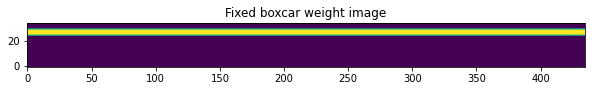

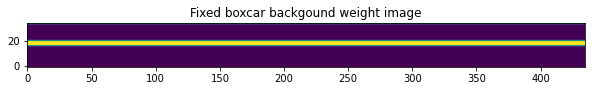

In [15]:
disp_axis = 1
crossdisp_axis = (0,)
    
# visualize the weight images used in the fixed boxcar extraction 
wimage_fixedboxcar, wimage_fb_bkg = ap_weight_images(ext_center, ext_width, disp_axis,
                                                     crossdisp_axis, bkg_offset, bkg_width, 
                                                     image.shape)

norm_data = simple_norm(wimage_fixedboxcar)
plt.figure(figsize=(10, 3))
plt.imshow(wimage_fixedboxcar, norm=norm_data, origin="lower")
plt.title("Fixed boxcar weight image")

norm_data = simple_norm(wimage_fb_bkg)
plt.figure(figsize=(10, 3))
plt.imshow(wimage_fb_bkg, norm=norm_data, origin="lower")
plt.title("Fixed boxcar backgound weight image")

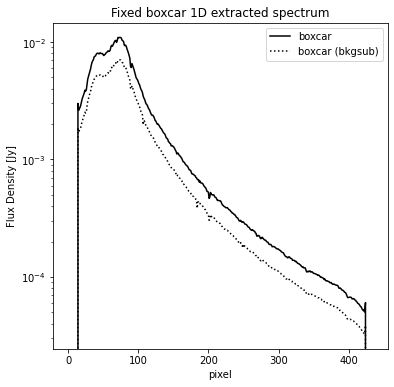

In [16]:
# extract the spectrum using the weight images

jdatamodel = s2d.slits[0]
image = jdatamodel.data

# without background subtraction
ext1d_boxcar, tmpval = extract_1dspec(image, jdatamodel, ext_center, ext_width, disp_axis, 
                                      crossdisp_axis, None, None)

# with background subtraction
ext1d_boxcar_bkgsub, tmpval = extract_1dspec(image, jdatamodel, ext_center, ext_width, disp_axis,
                                             crossdisp_axis, bkg_offset, bkg_width)

# plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(ext1d_boxcar, 'k-', label="boxcar")
ax.plot(ext1d_boxcar_bkgsub, 'k:', label="boxcar (bkgsub)")
ax.set_title("Fixed boxcar 1D extracted spectrum")
ax.set_xlabel(r"pixel")
ax.set_ylabel("Flux Density [Jy]")
ax.set_yscale("log")
ax.legend()

The flux density scale above does not match the pipeline extraction. We should verify the correctness of units conversions in the extraction process. The mismatch is likely caused by the lack of a wavelength scale in the extracted product.

## Ingest s3d data

In [17]:
# NIRSpec IFU science data cube
s3dfilename = "NRS00001-faintQSO-F100LP-G140H-01_1_491_SE_2020-08-25T12h15m00_s3d.fits"
mainurl = "https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_optimal_extraction/"
s3dfile_dld = download_file(mainurl + s3dfilename)

# rename files so that they have the right extensions required for the jwst datamodels to work
s3dfile = s3dfile_dld + '_s3d.fits'
os.rename(s3dfile_dld, s3dfile)

s3d = datamodels.open(s3dfile)
image = s3d.data

DEBUG:jwst.datamodels.util:Opening /var/folders/f2/dsq1cxxd78n9vltk6_6kwxtr0000zf/T/astropy-download-14721-nc29k3al_s3d.fits as <class 'jwst.datamodels.ifucube.IFUCubeModel'>
DEBUG:stpipe:Opening /var/folders/f2/dsq1cxxd78n9vltk6_6kwxtr0000zf/T/astropy-download-14721-nc29k3al_s3d.fits as <class 'jwst.datamodels.ifucube.IFUCubeModel'>


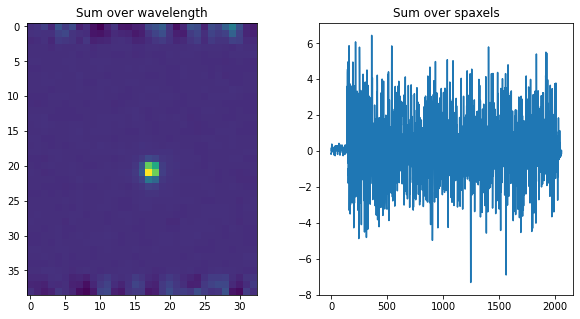

In [18]:
# Inspect sums over wavelengths and spaxels
data = np.nan_to_num(np.array(image))
sum_over_waves = np.sum(data, axis=(0))
sum_over_spaxels = np.sum(data, axis=(1, 2))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5)) 
ax1.imshow(sum_over_waves)
ax1.set_title("Sum over wavelength")
ax2.plot(sum_over_spaxels) 
ax2.set_title("Sum over spaxels")
plt.show()

## Extraction code test with s3d data

In [19]:
# extraction parameters based on sum-over-wavelength image 
ext_center = (16, 20)
ext_width = 6
bkg_offset = 4
bkg_width = 2

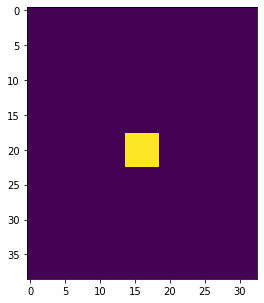

In [20]:
# build weight image (no background yet)
disp_axis = 0
crossdisp_axis = (1,2)
    
wimage_fixedboxcar, wimage_fb_bkg = ap_weight_images(ext_center, ext_width, disp_axis,
                                                     crossdisp_axis, bkg_offset, 
                                                     bkg_width, image.shape)

d1 = np.average(wimage_fixedboxcar, axis=0)
f, ax = plt.subplots(1, figsize=(5, 5))
ax.imshow(d1)
plt.show()

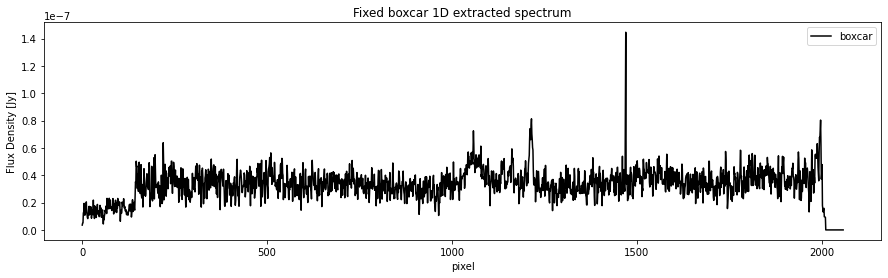

In [21]:
# extract the spectrum (no bkg subtraction for now)

jdatamodel = s3d
image = jdatamodel.data

ext1d_boxcar, tmpval = extract_1dspec(image, jdatamodel, ext_center, ext_width, disp_axis, 
                                      crossdisp_axis, None, None)

# plot
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(ext1d_boxcar, 'k-', label="boxcar")
ax.set_title("Fixed boxcar 1D extracted spectrum")
ax.set_xlabel(r"pixel")
ax.set_ylabel("Flux Density [Jy]")
ax.legend()

## About this notebook

**Author:** Ivo Busko, JWST
**Updated On:** 2021-12-03

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 